In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mamba_ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (5.1 kB)
Using cached ninja-1.13.0-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (180 kB)
  Created wheel for mamba_ssm: filename=mamba_ssm-2.2.5-cp312-cp312-linux_x86_64.whl size=532566033 sha256=c8b65fcabfb49a94456c9971619007218e4073f19a84fb6b3894f33d43bee4a1
  Stored in directory: /root/.cache/pip/wheels/21/55/c4/85b634055d6a9b599d27f5cbeacf353c6c532d8e2d8769960b
Successfully built mamba_ssm


In [ ]:
from mamba_ssm import Mamba

In [ ]:
import numpy as np
import h5py
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import os
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings

warnings.filterwarnings('ignore')


class EnhancedEEGProcessor:
    """
    EEG data processor for memory-based word learning experiments.
    Classifies remembered vs. forgotten trials during second language acquisition.
    """

    def __init__(self, base_path=None, data_ch_path=None, data_kr_path=None):
        self.base_path = base_path
        self.data_ch_path = data_ch_path or os.path.join(self.base_path, 'Data_ch')
        self.data_kr_path = data_kr_path or os.path.join(self.base_path, 'Data')

        self.ch_ch = list(range(63))
        self.g_ch = list(range(61))
        self.ch_rem = [0, 2, 6, 8, 29, 31, 51, 55]
        self.g_rem = [46, 49, 56, 58, 59, 60]

        for i in self.ch_rem:
            if i in self.ch_ch:
                self.ch_ch.remove(i)
        for j in self.g_rem:
            if j in self.g_ch:
                self.g_ch.remove(j)

        self.X_all = []
        self.y_all = []
        self.subjects_info = []
        self.fs = 100

        self.filter_settings = {
            'bandpass': {'low': 0.5, 'high': 45.0},
            'notch': 50.0,
            'order': 4
        }

        self.bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }

    def load_chinese_data(self, condition="ASK", max_subjects=9, custom_path=None):
        print(f"Loading Chinese data ({condition})")

        for subj in range(1, max_subjects + 1):
            if custom_path:
                file_path = f'{custom_path}/data_ch/{condition}/sbj_{subj}.mat'
            else:
                file_path = os.path.join(self.data_ch_path, f'{condition}/sbj_{subj}.mat')

            try:
                print(f"Loading file: {file_path}")
                mat_data = loadmat(file_path)
                X = np.array(mat_data['x_post'])[:-1, self.ch_ch, :]
                y = np.array(mat_data['label_next_ind'])[0, :]
                X = np.transpose(X)

                self.X_all.append(X)
                self.y_all.append(y)
                self.subjects_info.append(f"Chinese_{condition}_sbj_{subj}")
                print(f"  Data shape X: {X.shape}, labels y: {y.shape}")

            except Exception as e:
                print(f"Error loading file {file_path}: {e}")

    def load_korean_data(self, condition="ASK", max_subjects=14, custom_path=None):
        print(f"Loading Korean data ({condition})")

        for subj in range(1, max_subjects + 1):
            if custom_path:
                file_path = f'{custom_path}/data/{condition}/sbj_{subj}.mat'
            else:
                file_path = os.path.join(self.data_kr_path, f'{condition}/sbj_{subj}.mat')

            try:
                with h5py.File(file_path, 'r') as f:
                    print(f"Loading file: {file_path}")
                    X = np.array(f['x_post'])[:, self.g_ch, :]
                    y = np.array(f['label_next_ind'])[:, 0]

                self.X_all.append(X)
                self.y_all.append(y)
                self.subjects_info.append(f"Korean_{condition}_sbj_{subj}")
                print(f"  Data shape X: {X.shape}, labels y: {y.shape}")

            except Exception as e:
                print(f"Error loading file {file_path}: {e}")

    def apply_bandpass_filter(self, data):
        low = self.filter_settings['bandpass']['low']
        high = self.filter_settings['bandpass']['high']
        order = self.filter_settings['order']

        b, a = signal.butter(order, [low/(self.fs/2), high/(self.fs/2)], btype='band')

        filtered_data = np.zeros_like(data)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                filtered_data[i, j, :] = signal.filtfilt(b, a, data[i, j, :])

        return filtered_data

    def apply_notch_filter(self, data):
        notch_freq = self.filter_settings['notch']
        quality_factor = 30.0

        b, a = signal.iirnotch(notch_freq, quality_factor, self.fs)

        filtered_data = np.zeros_like(data)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                filtered_data[i, j, :] = signal.filtfilt(b, a, data[i, j, :])

        return filtered_data

    def extract_frequency_features(self, data):
        n_trials, n_channels, n_times = data.shape
        n_bands = len(self.bands)
        features = np.zeros((n_trials, n_channels * n_bands))

        for i in range(n_trials):
            for j in range(n_channels):
                signal_fft = np.abs(np.fft.fft(data[i, j, :]))
                signal_fft = signal_fft[:n_times//2]
                freqs = np.fft.fftfreq(n_times, 1/self.fs)
                freqs = freqs[:n_times//2]

                for k, (band_name, (low, high)) in enumerate(self.bands.items()):
                    idx_band = np.logical_and(freqs >= low, freqs <= high)
                    if np.any(idx_band):
                        band_power = np.mean(signal_fft[idx_band])
                    else:
                        band_power = 0
                    features[i, j * n_bands + k] = band_power

        return features

    def normalize_per_subject(self, data_list, scaler_type='robust'):
        normalized_data_list = []

        for i, data in enumerate(data_list):
            n_trials, n_channels, n_times = data.shape

            if scaler_type == 'robust':
                scaler = RobustScaler()
            else:
                scaler = StandardScaler()

            data_flat = data.reshape(n_trials, -1)
            data_norm = scaler.fit_transform(data_flat)
            data_norm = data_norm.reshape(n_trials, n_channels, n_times)
            normalized_data_list.append(data_norm)

        return normalized_data_list

    def preprocess_data_trialwise_split_and_balance_all(self, use_freq_features=True,
                                                        normalize_subjects=True,
                                                        balance_method='smote',
                                                        apply_filters=True,
                                                        test_size=0.1,
                                                        val_size=0.1):
        if not self.X_all:
            raise ValueError("Data not loaded. Call load_chinese_data() and/or load_korean_data() first.")

        print("Step 1: Filtering and normalization...")
        X_list = [X.copy() for X in self.X_all]
        y_list = [y.copy() for y in self.y_all]

        if apply_filters:
            print("  Applying bandpass and notch filters...")
            for i in range(len(X_list)):
                X_list[i] = self.apply_bandpass_filter(X_list[i])
                X_list[i] = self.apply_notch_filter(X_list[i])

        if normalize_subjects:
            print("  Normalizing data per subject using RobustScaler...")
            X_list = self.normalize_per_subject(X_list, scaler_type='robust')

        print("\nStep 2: Concatenating all trials...")
        X_all_trials = np.concatenate(X_list, axis=0)
        y_all_trials = np.concatenate(y_list, axis=0)
        print(f"  Combined data shape: {X_all_trials.shape}")
        print(f"  Combined labels shape: {y_all_trials.shape}")
        print(f"  Class distribution: {np.bincount(y_all_trials.astype(int))}")

        print("\nStep 3: Performing trial-wise split...")
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_all_trials, y_all_trials,
            test_size=test_size,
            random_state=42,
            stratify=y_all_trials
        )

        val_ratio_adjusted = val_size / (1.0 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_ratio_adjusted,
            random_state=42,
            stratify=y_temp
        )

        print(f"  Train set: {X_train.shape}")
        print(f"  Validation set: {X_val.shape}")
        print(f"  Test set: {X_test.shape}")
        print(f"  Train class distribution: {np.bincount(y_train.astype(int))}")
        print(f"  Validation class distribution: {np.bincount(y_val.astype(int))}")
        print(f"  Test class distribution: {np.bincount(y_test.astype(int))}")

        print("\nStep 4: Feature extraction...")
        if use_freq_features:
            print("  Extracting frequency domain features...")
            train_freq = self.extract_frequency_features(X_train)
            val_freq = self.extract_frequency_features(X_val)
            test_freq = self.extract_frequency_features(X_test)

            X_train_features = np.hstack([
                X_train.reshape(X_train.shape[0], -1),
                train_freq
            ])
            X_val_features = np.hstack([
                X_val.reshape(X_val.shape[0], -1),
                val_freq
            ])
            X_test_features = np.hstack([
                X_test.reshape(X_test.shape[0], -1),
                test_freq
            ])
            print(f"  Feature dimensions after extraction: {X_train_features.shape[1]}")
        else:
            X_train_features = X_train.reshape(X_train.shape[0], -1)
            X_val_features = X_val.reshape(X_val.shape[0], -1)
            X_test_features = X_test.reshape(X_test.shape[0], -1)
            print(f"  Using time-domain features only: {X_train_features.shape[1]} features")

        def balance(X, y, method, name):
            if method == 'smote':
                print(f"  Applying SMOTE to {name} set...")
                sampler = SMOTE(random_state=42)
            elif method == 'undersample':
                print(f"  Applying random undersampling to {name} set...")
                sampler = RandomUnderSampler(random_state=42)
            else:
                return X, y

            X_bal, y_bal = sampler.fit_resample(X, y)
            print(f"  {name.capitalize()} set after balancing: {X_bal.shape}")
            print(f"  {name.capitalize()} class distribution: {np.bincount(y_bal.astype(int))}")
            return X_bal, y_bal

        print("\nStep 5: Balancing datasets...")
        X_train_bal, y_train_bal = balance(X_train_features, y_train, balance_method, "train")
        X_val_bal, y_val_bal = balance(X_val_features, y_val, balance_method, "validation")
        X_test_bal, y_test_bal = balance(X_test_features, y_test, balance_method, "test")

        if not use_freq_features:
            print("\nStep 6: Restoring 3D shape for time-domain data...")
            channels = X_all_trials.shape[1]
            timesteps = X_all_trials.shape[2]

            X_train_bal = X_train_bal.reshape(-1, channels, timesteps)
            X_val_bal = X_val_bal.reshape(-1, channels, timesteps)
            X_test_bal = X_test_bal.reshape(-1, channels, timesteps)
            print(f"  Restored shape: {X_train_bal.shape}")

        print("\nPreprocessing complete!")
        return {
            'X_train': X_train_bal,
            'y_train': y_train_bal,
            'X_val': X_val_bal,
            'y_val': y_val_bal,
            'X_test': X_test_bal,
            'y_test': y_test_bal,
            'train_subjects': None,
            'val_subjects': None,
            'test_subjects': None
        }

In [ ]:
# Initialize EEG Processor
custom_path = '/content/drive/MyDrive/source_localization'
processor = EnhancedEEGProcessor(base_path=custom_path)

# Load data from both datasets (ASK condition - memory retrieval)
processor.load_chinese_data(condition="ASK", custom_path=custom_path)
processor.load_korean_data(condition="ASK", custom_path=custom_path)

# Preprocess data with trial-wise split (80-10-10)
# Applies filtering, normalization, balancing
processed_data = processor.preprocess_data_trialwise_split_and_balance_all(
    normalize_subjects=True,         # RobustScaler per subject
    balance_method='undersample',    # Balance remembered/forgotten classes
    apply_filters=True,              # Bandpass (0.5-45 Hz) + notch (50 Hz)
    use_freq_features=False,         # Time-domain features only
    test_size=0.1,
    val_size=0.1
)

# Extract preprocessed datasets
X_train = processed_data['X_train']  # Shape: (trials, channels, timepoints)
y_train = processed_data['y_train']  # Labels: 0=forgotten, 1=remembered
X_val = processed_data['X_val']
y_val = processed_data['y_val']
X_test = processed_data['X_test']
y_test = processed_data['y_test']

train_subjects = processed_data['train_subjects']
val_subjects = processed_data['val_subjects']
test_subjects = processed_data['test_subjects']

num_epochs = 30

Загрузка китайских данных (ASK)
Загрузка файла: /content/drive/MyDrive/source_localization/data_ch/ASK/sbj_1.mat
  Форма данных X: (996, 55, 100), метки y: (996,)
Загрузка файла: /content/drive/MyDrive/source_localization/data_ch/ASK/sbj_2.mat
  Форма данных X: (884, 55, 100), метки y: (884,)
Загрузка файла: /content/drive/MyDrive/source_localization/data_ch/ASK/sbj_3.mat
  Форма данных X: (1291, 55, 100), метки y: (1291,)
Загрузка файла: /content/drive/MyDrive/source_localization/data_ch/ASK/sbj_4.mat
  Форма данных X: (908, 55, 100), метки y: (908,)
Загрузка файла: /content/drive/MyDrive/source_localization/data_ch/ASK/sbj_5.mat
  Форма данных X: (882, 55, 100), метки y: (882,)
Загрузка файла: /content/drive/MyDrive/source_localization/data_ch/ASK/sbj_6.mat
  Форма данных X: (904, 55, 100), метки y: (904,)
Загрузка файла: /content/drive/MyDrive/source_localization/data_ch/ASK/sbj_7.mat
  Форма данных X: (942, 55, 100), метки y: (942,)
Загрузка файла: /content/drive/MyDrive/source_loc

In [ ]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba


class ConvEncoder(nn.Module):
    """1D Convolutional Encoder with normalization."""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.norm = nn.LayerNorm(in_channels)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.norm(x)
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        x = x.transpose(1, 2)
        return x


class STMambaNet(nn.Module):
    """
    Spatio-Temporal Mamba Network for EEG-based Memory Classification.

    Processes EEG signals through separate spatial and temporal pathways using
    Mamba state-space models for classifying remembered vs. forgotten trials.
    """

    def __init__(self, input_size, hidden_size, num_classes):
        super(STMambaNet, self).__init__()

        # Multi-scale temporal convolution
        self.kernel_sizes = [5, 9]
        self.conv_channels = [8, 8]
        self.temp_convs = nn.ModuleList([
            nn.Conv2d(1, out_ch, kernel_size=(1, k), padding=(0, k // 2))
            for k, out_ch in zip(self.kernel_sizes, self.conv_channels)
        ])

        # Spatial processing
        self.total_conv_channels = sum(self.conv_channels)
        self.batch_norm1 = nn.BatchNorm2d(self.total_conv_channels)
        self.spatial_conv = nn.Conv2d(self.total_conv_channels, self.total_conv_channels,
                                      kernel_size=(1, 1))
        self.batch_norm2 = nn.BatchNorm2d(self.total_conv_channels)
        self.activation = nn.ELU()

        # Statistical pooling
        self.var_pool = lambda x: torch.var(x, dim=1, keepdim=True)
        self.avg_pool = lambda x: torch.mean(x, dim=1, keepdim=True)

        # Feedforward networks for Mamba blocks
        self.feedforward_1 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        self.feedforward_2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

        # Normalization and regularization
        self.norm_t = nn.LayerNorm(128)
        self.norm_s = nn.LayerNorm(128)
        self.dropout = nn.Dropout(0.4)

        # Temporal Mamba block
        self.proj_t_in = nn.Linear(55, 128)
        self.proj_t_out = nn.Linear(128, 55)
        self.mamba_t = Mamba(d_model=128, d_state=16)

        # Spatial Mamba block
        self.proj_s_in = nn.Linear(100, 128)
        self.proj_s_out = nn.Linear(128, 100)
        self.mamba_s = Mamba(d_model=128, d_state=16)

        # Convolutional encoders
        self.conv_t = ConvEncoder(in_channels=110, out_channels=55)
        self.conv_s = ConvEncoder(in_channels=200, out_channels=100)

        # Pooling layers
        self.pool_t = nn.Identity()
        self.pool_s = nn.Identity()

        # Fully connected layers
        self.fc_s = nn.Sequential(
            nn.Linear(55 * 100, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc_t = nn.Sequential(
            nn.Linear(100 * 55, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion and classification
        self.fusion = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc_class = nn.Linear(64, num_classes)

    def forward(self, x, mode="classification"):
        # Add channel dimension
        x = x.unsqueeze(1)  # [B, 1, channels, time]

        # Multi-scale temporal convolution
        x = torch.cat([conv(x) for conv in self.temp_convs], dim=1)
        x = self.batch_norm1(x)

        # Spatial convolution
        x = self.spatial_conv(x)
        x = self.batch_norm2(x)
        x = self.activation(x)

        # Dual statistical pooling
        x_var = self.var_pool(x).permute(0, 2, 3, 1).squeeze(-1)
        x_avg = self.avg_pool(x).permute(0, 2, 3, 1).squeeze(-1)

        # Shared Mamba block processing
        def shared_mamba_block(x, mamba, norm, feedforward, proj_in, proj_out):
            res1 = x
            x = proj_in(x)
            x = norm(x)
            x = mamba(x)
            x = self.dropout(x) + proj_in(res1)

            res2 = x
            x = norm(x)
            x = feedforward(x)
            x = proj_out(x + res2)
            return x

        # Temporal Mamba processing
        x_tvar = shared_mamba_block(x_var.permute(0, 2, 1), self.mamba_t,
                                    self.norm_t, self.feedforward_1,
                                    self.proj_t_in, self.proj_t_out)
        x_tavg = shared_mamba_block(x_avg.permute(0, 2, 1), self.mamba_t,
                                    self.norm_t, self.feedforward_1,
                                    self.proj_t_in, self.proj_t_out)
        x_t = torch.cat([x_tvar, x_tavg], dim=-1)

        # Spatial Mamba processing
        x_svar = shared_mamba_block(x_var, self.mamba_s, self.norm_s,
                                    self.feedforward_2, self.proj_s_in, self.proj_s_out)
        x_savg = shared_mamba_block(x_avg, self.mamba_s, self.norm_s,
                                    self.feedforward_2, self.proj_s_in, self.proj_s_out)
        x_s = torch.cat([x_svar, x_savg], dim=-1)

        # Convolutional encoding
        x_tconv = self.conv_t(x_t)
        x_sconv = self.conv_s(x_s).permute(0, 2, 1)

        # Pooling and flattening
        x_tconv = self.pool_t(x_tconv).reshape(x_tconv.size(0), -1)
        x_sconv = self.pool_s(x_sconv).reshape(x_sconv.size(0), -1)

        # Feature extraction
        x_sfc = self.fc_s(x_sconv)
        x_tfc = self.fc_t(x_tconv)

        # Feature fusion
        x_fused = torch.cat([x_sfc, x_tfc], dim=1)
        x_fused = self.fusion(x_fused)

        # Classification
        return self.fc_class(x_fused)

In [ ]:
# Convert NumPy arrays to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy


# Hyperparameters
batch_size = 32
num_epochs_train = 20
learning_rate = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on device: {device}")

# Data loaders
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=batch_size,
    shuffle=False
)

# Model initialization
feature_dim = X_train_t.shape[1]
hidden_size = 100
num_classes = len(torch.unique(y_train_t))

print(f"Model configuration:")
print(f"  Input channels: {feature_dim}")
print(f"  Hidden size: {hidden_size}")
print(f"  Output classes: {num_classes}")

model = STMambaNet(
    input_size=feature_dim,
    hidden_size=hidden_size,
    num_classes=num_classes
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=20, patience=3):
    """
    Train the STMambaNet model with early stopping.

    Args:
        model: STMambaNet model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Maximum number of training epochs
        patience: Early stopping patience

    Returns:
        Trained model with best validation accuracy weights
    """
    best_val_acc = 0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch, mode="classification")
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch = X_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)

                val_outputs = model(X_val_batch, mode="classification")
                val_correct += (val_outputs.argmax(1) == y_val_batch).sum().item()
                val_total += y_val_batch.size(0)

        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Loss: {avg_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        # Model checkpointing and early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(f"✓ New best model saved! (Val Acc: {val_acc:.4f})")
        else:
            epochs_no_improve += 1
            print(f"⨯ No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
            print(f"⚠ Best validation accuracy: {best_val_acc:.4f}")
            break

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Loaded best model (Val Acc: {best_val_acc:.4f})")
    else:
        print("\n⚠ No model improvement detected during training")

    return model


# Execute training
print("\n" + "="*70)
print("Starting Model Training")
print("="*70 + "\n")

trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs_train
)

print("\n" + "="*70)
print("Training Complete")
print("="*70 + "\n")

Epoch 1/20 | Loss: 0.6907 | Train Acc: 0.5204 | Val Acc: 0.5474
New best model saved!
Epoch 2/20 | Loss: 0.6836 | Train Acc: 0.5495 | Val Acc: 0.5444
No improvement for 1 epoch(s)
Epoch 3/20 | Loss: 0.6715 | Train Acc: 0.5821 | Val Acc: 0.6012
New best model saved!
Epoch 4/20 | Loss: 0.6523 | Train Acc: 0.6172 | Val Acc: 0.6302
New best model saved!
Epoch 5/20 | Loss: 0.6396 | Train Acc: 0.6330 | Val Acc: 0.6151
No improvement for 1 epoch(s)
Epoch 6/20 | Loss: 0.6285 | Train Acc: 0.6483 | Val Acc: 0.6239
No improvement for 2 epoch(s)
Epoch 7/20 | Loss: 0.6177 | Train Acc: 0.6624 | Val Acc: 0.6028
No improvement for 3 epoch(s)
Early stopping triggered.
Loaded best model from training.


Test Accuracy: 0.6149


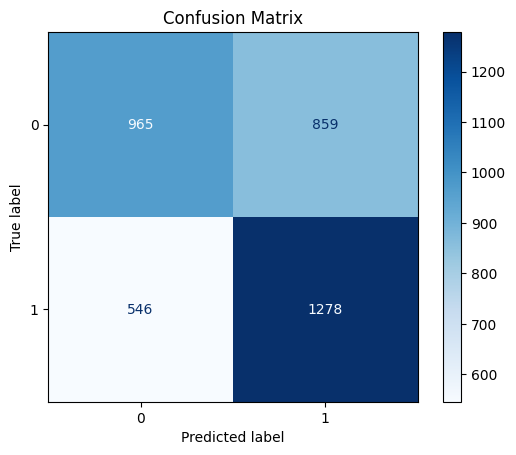

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Prepare test data loader
test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def evaluate_test(model, test_loader):
    """Evaluate trained model on test set and visualize results."""
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch = X_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)

            outputs = model(X_test_batch, mode="classification")
            _, preds = torch.max(outputs, 1)

            correct += (preds == y_test_batch).sum().item()
            total += y_test_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test_batch.cpu().numpy())

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Test Set")
    plt.show()


# Run evaluation
print("\nEvaluating on test set...")
evaluate_test(trained_model, test_loader)

In [ ]:
import torch
import numpy as np


@torch.no_grad()
def compute_2d_importance_by_class_batched(
    model,
    X,
    y,
    window_size=10,
    stride=2,
    max_samples=None,
    mode='pred',
    relative=False,
    ignore_negative=True,
    batch_windows=256,
    return_per_sample=False,
    only_correct=True
):
    """
    Compute 2D importance maps using sliding window perturbation analysis.

    Args:
        model: Trained neural network model
        X: EEG data (samples, channels, timepoints)
        y: True labels (0=forgotten, 1=remembered)
        window_size: Size of perturbation window
        stride: Step size between windows
        max_samples: Maximum samples per class
        mode: 'pred' or 'true' class for importance
        relative: Normalize by baseline confidence
        ignore_negative: Clamp negative values to 0
        batch_windows: Windows to process in parallel
        return_per_sample: Return individual maps
        only_correct: Filter by prediction correctness

    Returns:
        remembered_avg, forgotten_avg: Average importance maps (C, T)
    """
    if stride is None:
        stride = 2

    device = next(model.parameters()).device
    model.eval()

    def make_bucket():
        return {
            'remembered_maps': [],
            'forgotten_maps': [],
            'remembered_count': 0,
            'forgotten_count': 0,
            'skipped_incorrect': 0,
        }

    if only_correct == "separate":
        buckets = {'correct': make_bucket(), 'incorrect': make_bucket()}
    else:
        buckets = {'all': make_bucket()}

    def per_class_limit_for(bucket_name):
        if max_samples is None:
            return float('inf')
        return max_samples // 2

    N = len(X)
    for i in range(N):
        xi = X[i]
        label = int(y[i])

        x_tensor = torch.as_tensor(
            xi if isinstance(xi, np.ndarray) else xi.cpu().numpy(),
            dtype=torch.float32
        )
        x_tensor = x_tensor.clone().unsqueeze(0).to(device)

        out = model(x_tensor)
        probs = torch.softmax(out, dim=1)
        pred_label = probs.argmax(dim=1).item()
        is_correct = (pred_label == label)

        if only_correct is True and not is_correct:
            buckets['all']['skipped_incorrect'] += 1
            continue

        bucket_key = 'all' if only_correct in (True, False) else ('correct' if is_correct else 'incorrect')
        bucket = buckets[bucket_key]

        pcl = per_class_limit_for(bucket_key)
        if label == 1 and bucket['remembered_count'] >= pcl:
            continue
        if label == 0 and bucket['forgotten_count'] >= pcl:
            continue

        class_idx = label if mode == 'true' else pred_label
        original_conf = probs[0, class_idx].item()
        base = max(original_conf, 1e-8)

        _, C, T = x_tensor.shape
        heatmap = torch.zeros(C, T, device=device)
        cover = torch.zeros_like(heatmap)

        starts = list(range(0, T, stride))
        if starts[-1] + window_size < T:
            starts.append(T - window_size)

        for ch in range(C):
            for batch_start in range(0, len(starts), batch_windows):
                batch_starts = starts[batch_start: batch_start + batch_windows]
                B = len(batch_starts)

                perturbed = x_tensor.repeat(B, 1, 1)
                for bi, s in enumerate(batch_starts):
                    e = min(s + window_size, T)
                    perturbed[bi, ch, s:e] = 0.0

                new_out = model(perturbed)
                new_probs = torch.softmax(new_out, dim=1)[:, class_idx]
                new_conf = new_probs.detach().cpu().numpy()

                if relative:
                    drops = (original_conf - new_conf) / base
                else:
                    drops = (original_conf - new_conf)

                if ignore_negative:
                    drops = np.maximum(drops, 0.0)

                for s, drop in zip(batch_starts, drops):
                    e = min(s + window_size, T)
                    heatmap[ch, s:e] += drop
                    cover[ch, s:e] += 1

        heatmap = (heatmap / cover.clamp(min=1)).cpu().numpy()

        if label == 1:
            bucket['remembered_maps'].append(heatmap)
            bucket['remembered_count'] += 1
        else:
            bucket['forgotten_maps'].append(heatmap)
            bucket['forgotten_count'] += 1

    def finalize_bucket(b):
        rem_avg = np.mean(np.stack(b['remembered_maps']), axis=0) if b['remembered_maps'] else None
        fog_avg = np.mean(np.stack(b['forgotten_maps']), axis=0) if b['forgotten_maps'] else None

        out = {
            'remembered_avg': rem_avg,
            'forgotten_avg': fog_avg,
            'counts': {
                'remembered': b['remembered_count'],
                'forgotten': b['forgotten_count'],
            }
        }

        if 'skipped_incorrect' in b:
            out['skipped_incorrect'] = b['skipped_incorrect']

        if return_per_sample:
            out['remembered_maps'] = b['remembered_maps']
            out['forgotten_maps'] = b['forgotten_maps']

        return out

    if only_correct == "separate":
        return {
            'correct': finalize_bucket(buckets['correct']),
            'incorrect': finalize_bucket(buckets['incorrect'])
        }
    else:
        b = finalize_bucket(buckets['all'])
        if return_per_sample:
            return b['remembered_avg'], b['forgotten_avg'], b['remembered_maps'], b['forgotten_maps']
        else:
            return b['remembered_avg'], b['forgotten_avg']

In [ ]:
res_true = compute_2d_importance_by_class_batched(
    model, X_train, y_train,
    mode='true',            # measure drop for the true class
    only_correct="separate"
)
wrong_true_rem = res_true['incorrect']['remembered_avg']
wrong_true_fog = res_true['incorrect']['forgotten_avg']


In [ ]:
correct_true_rem = res_true['correct']['remembered_avg']
correct_true_fog = res_true['correct']['forgotten_avg']

In [ ]:
ch_names = [
    'F5', 'F1', 'Fz', 'F2', 'F6', 'FFT7', 'FFT8', 'FTT9', 'FTT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FTT10', 'FTT8', 'FCC5', 'FCC3', 'FCC1', 'FCC2', 'FCC4', 'FCC6',
    'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TPP9', 'TPP7', 'CP5', 'CP3',
    'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TPP10', 'TPP8', 'P5', 'P3', 'Pz', 'P4', 'P6', 'PO7',
    'PO3', 'POz', 'PO4', 'PO8', 'Oz'
]

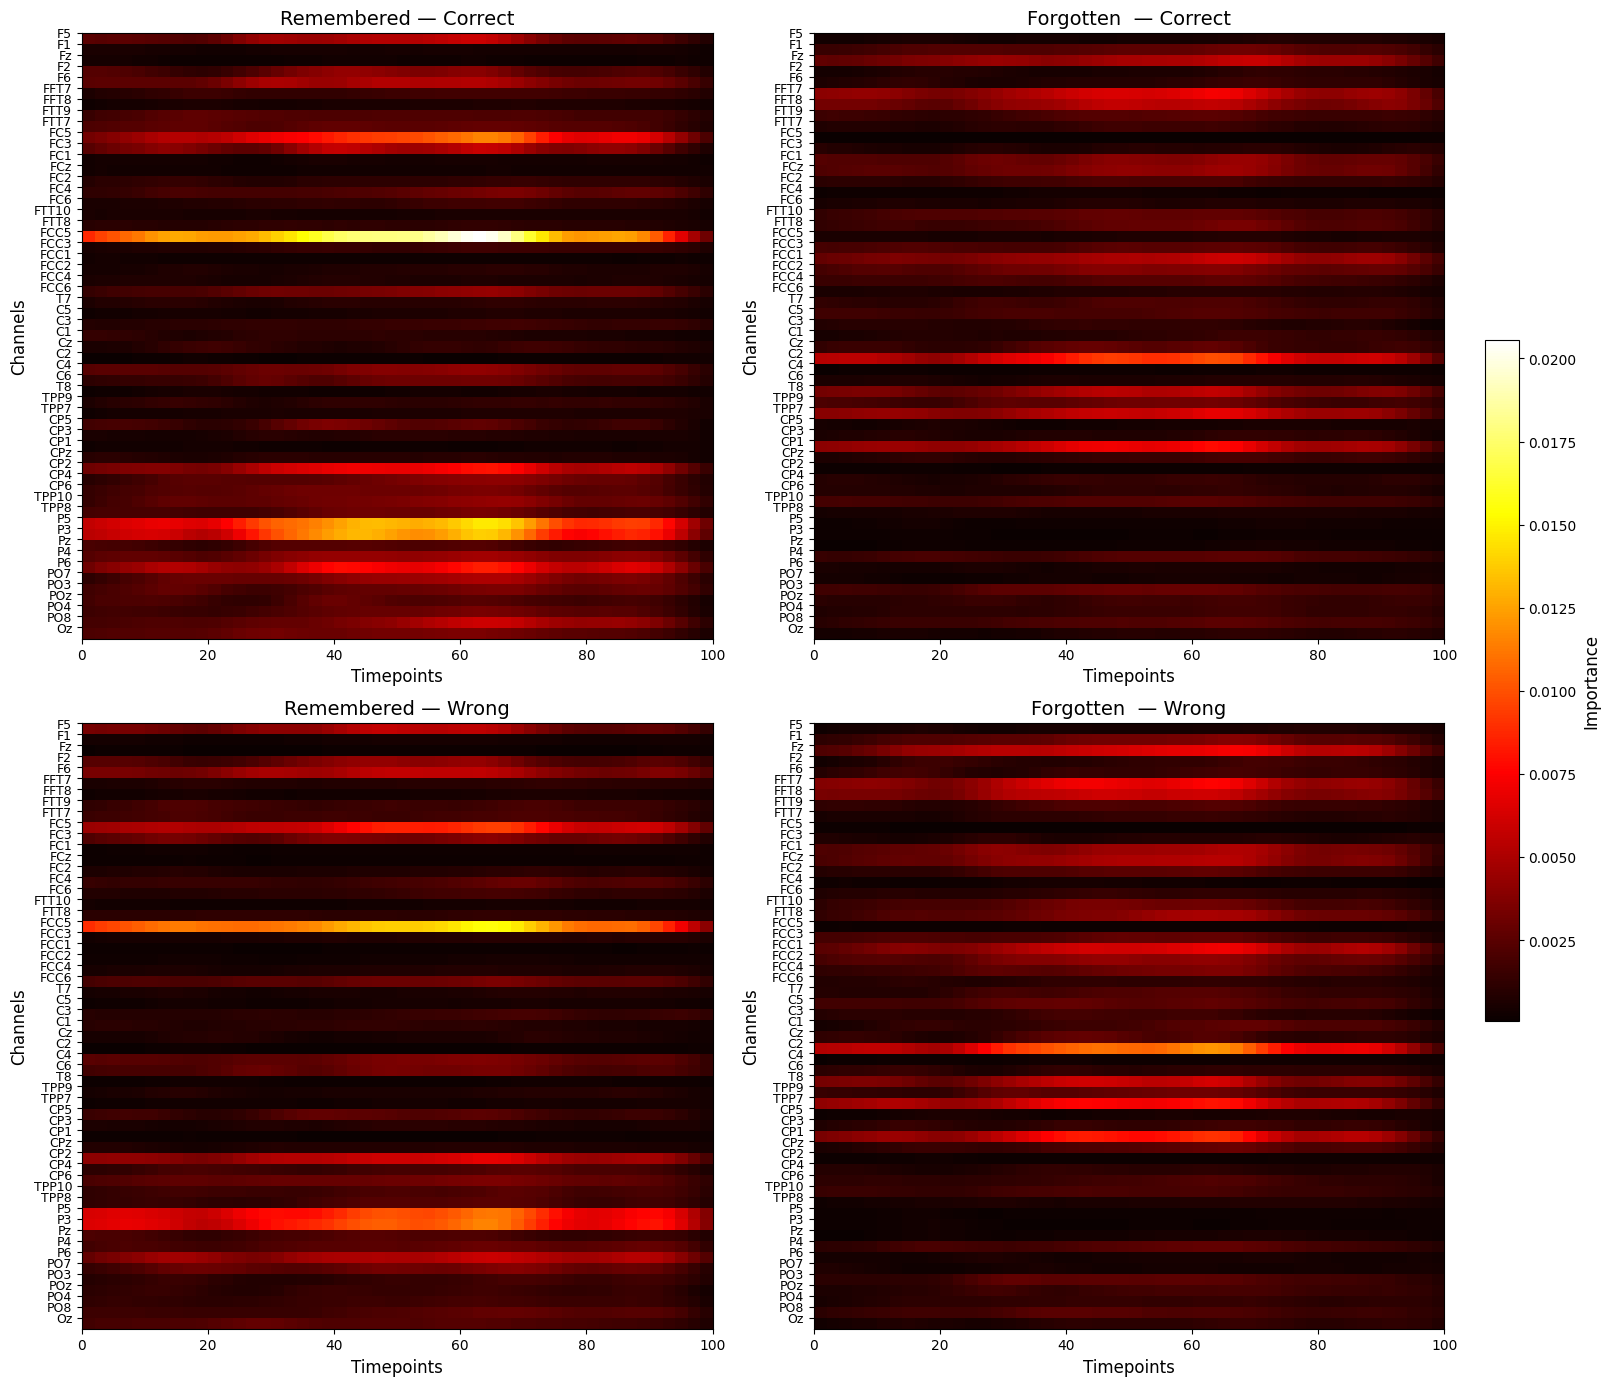

In [ ]:
"""
Visualization of 2D Importance Maps
===================================

Generates a 2×2 panel plot showing importance maps for:
- Correct predictions: remembered vs. forgotten
- Incorrect predictions: remembered vs. forgotten

"""

import matplotlib.pyplot as plt
import numpy as np


# ============================================================================
# Extract Importance Maps from Results
# ============================================================================
# Maps from incorrect predictions (model was wrong)
wrong_true_rem = res_true['incorrect']['remembered_avg']
wrong_true_fog = res_true['incorrect']['forgotten_avg']

# Maps from correct predictions (model was right)
correct_true_rem = res_true['correct']['remembered_avg']
correct_true_fog = res_true['correct']['forgotten_avg']


# ============================================================================
# Organize Panels for 2×2 Layout
# ============================================================================
# Row 1: Correct predictions | Row 2: Incorrect predictions
# Col 1: Remembered          | Col 2: Forgotten
panels = [
    ("Remembered — Correct",  correct_true_rem),
    ("Forgotten  — Correct",  correct_true_fog),
    ("Remembered — Wrong",    wrong_true_rem),
    ("Forgotten  — Wrong",    wrong_true_fog),
]

# Filter out None values (buckets with no samples)
available = [(t, a) for (t, a) in panels if a is not None]
if len(available) == 0:
    raise ValueError("All heatmaps are None (no samples in these buckets).")

# Compute global color scale for consistent comparison across panels
vmin = min(np.nanmin(a) for _, a in available)
vmax = max(np.nanmax(a) for _, a in available)

# Extract dimensions from first available array
C = available[0][1].shape[0]  # Number of channels
T = available[0][1].shape[1]  # Number of timepoints


# ============================================================================
# Create Figure with 2×2 Subplots
# ============================================================================
# Height scales with number of channels for readable labels
fig, axes = plt.subplots(2, 2, figsize=(16, max(8, C * 0.25)), constrained_layout=True)
axes = np.array(axes).reshape(2, 2)


# ============================================================================
# Helper Function to Draw Individual Panel
# ============================================================================
def draw(ax, title, arr):
    """Draw a single importance heatmap."""
    im = ax.imshow(arr, cmap='hot', aspect='auto',
                   extent=[0, T, C, 0], vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Timepoints", fontsize=12)
    ax.set_ylabel("Channels", fontsize=12)
    ax.set_yticks(np.arange(C))
    ax.set_yticklabels(ch_names[:C], fontsize=9)  # Channel names on y-axis
    ax.set_xticks(np.linspace(0, T, 6))
    ax.tick_params(axis='x', labelsize=10)
    return im


# ============================================================================
# Populate Subplots
# ============================================================================
# Map: (row, col) → panel data
slots = [(0,0), (0,1), (1,0), (1,1)]
ims = []

for (ax_rc, (title, arr)) in zip(slots, panels):
    r, c = ax_rc
    ax = axes[r, c]

    if arr is None:
        # Hide axis if no data available
        ax.axis('off')
        ims.append(None)
    else:
        # Draw heatmap
        ims.append(draw(ax, title, arr))


# ============================================================================
# Add Shared Colorbar
# ============================================================================
# Single colorbar for all panels (consistent color scale)
first_im = next((im for im in ims if im is not None), None)
if first_im is not None:
    cbar = fig.colorbar(first_im, ax=axes, fraction=0.025, pad=0.02)
    cbar.set_label("Importance", fontsize=12)

plt.show()

Mean importance (Remembered): correct vs wrong: 0.0024452896 0.0020102633
Correlation between maps: 0.9765141535419045


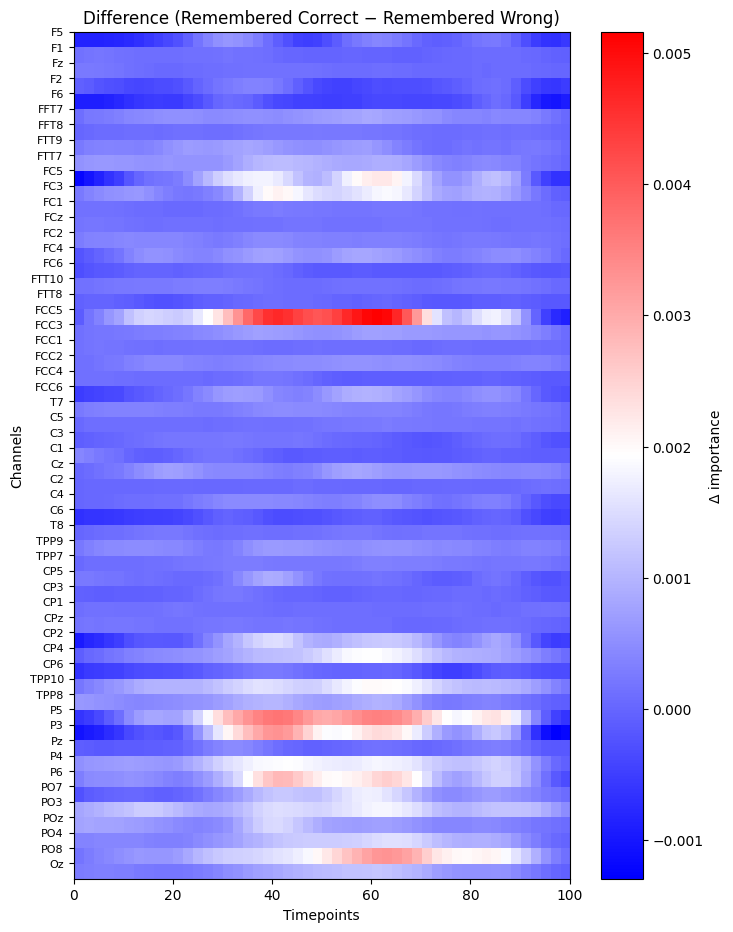

Top +Δ channels: ['FCC5', 'P5', 'PO8', 'P6', 'PO3', 'P4', 'TPP10', 'P3', 'FC3', 'CP4']
Timepoints with largest +Δ (indices): [60, 61, 62, 63, 59, 58, 39, 38, 40, 41]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

R_corr  = res_true['correct']['remembered_avg']
R_wrong = res_true['incorrect']['remembered_avg']

# print("Mean importance (Remembered): correct vs wrong:",
#       R_corr.mean(), R_wrong.mean())
# print("Correlation between maps:", np.corrcoef(R_corr.ravel(), R_wrong.ravel())[0,1])

# Difference heatmap (positive = stronger in Correct)
delta = R_corr - R_wrong
C, T = delta.shape
plt.figure(figsize=(8, max(5, C*0.2)))
im = plt.imshow(delta, cmap='bwr', aspect='auto', extent=[0, T, C, 0])
plt.title("Difference (Remembered Correct − Remembered Wrong)")
plt.xlabel("Timepoints"); plt.ylabel("Channels")
plt.yticks(np.arange(C), ch_names[:C], fontsize=8)
plt.colorbar(im, label="Δ importance")
plt.show()

# # Where the difference concentrates
# time_profile = delta.mean(axis=0)   # over channels
# chan_profile = delta.mean(axis=1)   # over time
# print("Top +Δ channels:", [ch_names[i] for i in np.argsort(-chan_profile)[:10]])
# print("Timepoints with largest +Δ (indices):", np.argsort(-time_profile)[:10].tolist())

Remembered — Correct: peak at timepoint 62 with value 0.003469
Forgotten  — Correct: peak at timepoint 64 with value 0.002431
Remembered — Wrong: peak at timepoint 64 with value 0.002683
Forgotten  — Wrong: peak at timepoint 62 with value 0.002764


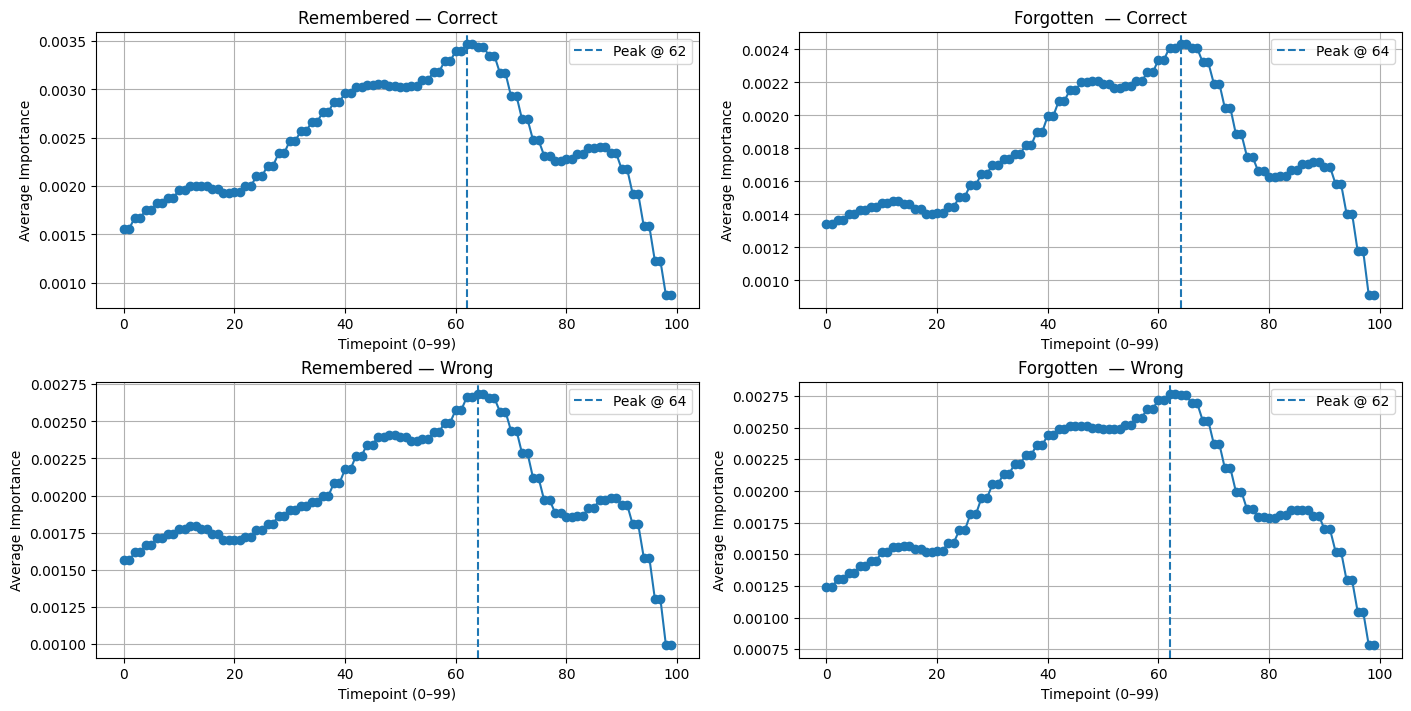

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

wrong_true_rem = res_true['incorrect']['remembered_avg']   # [C, T] or None
wrong_true_fog = res_true['incorrect']['forgotten_avg']    # [C, T] or None
correct_true_rem = res_true['correct']['remembered_avg']   # [C, T] or None
correct_true_fog = res_true['correct']['forgotten_avg']    # [C, T] or None

panels = [
    ("Remembered — Correct",  correct_true_rem),
    ("Forgotten  — Correct",  correct_true_fog),
    ("Remembered — Wrong",    wrong_true_rem),
    ("Forgotten  — Wrong",    wrong_true_fog),
]

def to_numpy(arr):
    if arr is None:
        return None
    if hasattr(arr, "detach"):  # torch tensor
        arr = arr.detach().cpu().numpy()
    return np.asarray(arr)

panels = [(title, to_numpy(arr)) for title, arr in panels]
available = [(t, a) for t, a in panels if a is not None]
if not available:
    raise ValueError("All inputs are None. Nothing to plot.")

# infer T from first available
T = available[0][1].shape[1]

# Compute time-mean curves and peaks
results = []  # (title, curve[T], peak_idx, peak_val)
for title, arr in panels:
    if arr is None:
        results.append((title, None, None, None))
        continue
    # arr: [C, T] -> mean over channels
    curve = arr.mean(axis=0)
    peak_idx = int(np.argmax(curve))
    peak_val = float(curve[peak_idx])
    results.append((title, curve, peak_idx, peak_val))

# # Print peaks
# for title, curve, peak_idx, peak_val in results:
#     if curve is None:
#         print(f"{title}: None (no samples)")
#     else:
#         print(f"{title}: peak at timepoint {peak_idx} with value {peak_val:.6f}")

# Plot 2×2
fig, axes = plt.subplots(2, 2, figsize=(14, 7), constrained_layout=True)
axes = axes.reshape(2, 2)

slots = [(0,0), (0,1), (1,0), (1,1)]
for (r, c), (title, curve, peak_idx, peak_val) in zip(slots, results):
    ax = axes[r, c]
    if curve is None:
        ax.axis('off')
        ax.set_title(f"{title} (no data)")
        continue

    ax.plot(curve, marker='o')
    ax.axvline(peak_idx, linestyle='--', label=f"Peak @ {peak_idx}")
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Timepoint (0–{})".format(T-1))
    ax.set_ylabel("Average Importance")
    ax.grid(True)
    ax.legend()

plt.show()

In [ ]:
import numpy as np

wrong_true_rem = res_true['incorrect']['remembered_avg']   # [C, T] or None
wrong_true_fog = res_true['incorrect']['forgotten_avg']    # [C, T] or None
correct_true_rem = res_true['correct']['remembered_avg']   # [C, T] or None
correct_true_fog = res_true['correct']['forgotten_avg']    # [C, T] or None

panels = [
    ("Remembered — Correct",  correct_true_rem),
    ("Forgotten  — Correct",  correct_true_fog),
    ("Remembered — Wrong",    wrong_true_rem),
    ("Forgotten  — Wrong",    wrong_true_fog),
]

def to_numpy(arr):
    if arr is None:
        return None
    if hasattr(arr, "detach"):  # torch tensor
        arr = arr.detach().cpu().numpy()
    return np.asarray(arr)

panels = [(title, to_numpy(arr)) for title, arr in panels]

# For each, compute mean over time (axis=1), take top-10 channels
for title, arr in panels:
    print(f"\n=== {title} ===")
    if arr is None:
        print("No data (None)")
        continue

    channel_mean = arr.mean(axis=1)  # [C]
    top_indices = np.argsort(channel_mean)[-10:][::-1]  # top 10, descending
    top_channels = [ch_names[i] for i in top_indices]
    # top_values = channel_mean[top_indices]

    # print("Top channel indices:", top_indices)
    print("Top channel names:", top_channels)
    # print("Top channel values:")
    # for name, val in zip(top_channels, top_values):
    #     print(f"  {name}: {val:.4f}")


=== Remembered — Correct ===
Top channel indices: [18 44 45  9 48 39 10  4  0 53]
Top channel names: ['FCC5', 'P5', 'P3', 'FC5', 'P6', 'CP2', 'FC3', 'F6', 'F5', 'PO8']
Top channel values:
  FCC5: 0.0139
  P5: 0.0099
  P3: 0.0091
  FC5: 0.0072
  P6: 0.0059
  CP2: 0.0054
  FC3: 0.0040
  F6: 0.0038
  F5: 0.0036
  PO8: 0.0036

=== Forgotten  — Correct ===
Top channel indices: [29 37  5 34 20  2  6 32 12 11]
Top channel names: ['C2', 'CP1', 'FFT7', 'TPP7', 'FCC1', 'Fz', 'FFT8', 'T8', 'FCz', 'FC1']
Top channel values:
  C2: 0.0067
  CP1: 0.0054
  FFT7: 0.0049
  TPP7: 0.0048
  FCC1: 0.0043
  Fz: 0.0042
  FFT8: 0.0041
  T8: 0.0040
  FCz: 0.0032
  FC1: 0.0031

=== Remembered — Wrong ===
Top channel indices: [18 45 44  9 39 48  4  0 10  3]
Top channel names: ['FCC5', 'P3', 'P5', 'FC5', 'CP2', 'P6', 'F6', 'F5', 'FC3', 'F2']
Top channel values:
  FCC5: 0.0116
  P3: 0.0081
  P5: 0.0079
  FC5: 0.0064
  CP2: 0.0049
  P6: 0.0046
  F6: 0.0042
  F5: 0.0038
  FC3: 0.0030
  F2: 0.0028

=== Forgotten  — W

In [ ]:
pwd

'/content'

In [ ]:
cd drive

/content/drive


In [ ]:
cd MyDrive

/content/drive/MyDrive


In [ ]:
cd CorrectAndWrong_TrainData_Run1/

/content/drive/MyDrive/CorrectAndWrong_TrainData_Run1


In [ ]:
ls

In [ ]:
import os, numpy as np, pandas as pd
from google.colab import drive

def save_arr(name, arr):
    if arr is None:
        return
    # .npy
    np.save((f"{name}.npy"), arr)
    # # CSV with channel names (rows) and timepoints (cols)
    # df = pd.DataFrame(arr,
    #                   index=ch_names[:arr.shape[0]],
    #                   columns=np.arange(arr.shape[1]))
    # df.to_csv(os.path.join(f"{name}.csv"))

save_arr("correct_true_rem", correct_true_rem)
save_arr("correct_true_fog", correct_true_fog)
save_arr("wrong_true_rem",   wrong_true_rem)
save_arr("wrong_true_fog",   wrong_true_fog)

In [ ]:
ls

correct_true_fog.csv  correct_true_rem.npy  wrong_true_rem.csv
correct_true_fog.npy  wrong_true_fog.csv    wrong_true_rem.npy
correct_true_rem.csv  wrong_true_fog.npy
